# Rover Lab Notebook

In [1]:
%matplotlib inline

# An option to plot to an interactive window
#%matplotlib qt 

In [2]:
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

### Quick look at the data

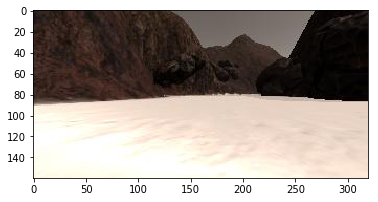

In [3]:
path = '../course_test_dataset/IMG/*'
#path = '../test_dataset/IMG/*'
img_list = glob.glob(path)

# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

### Calibration Data

Read in and display example grid and rock sample calibration images. Use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest.

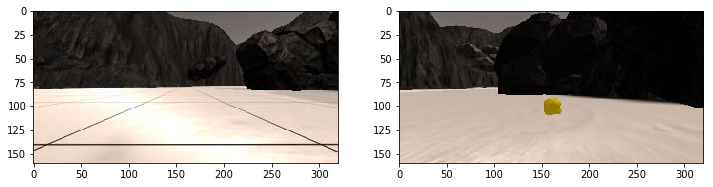

In [80]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples 
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

### Perspective Transform

Define the perspective transform function from the lesson and test it on an image

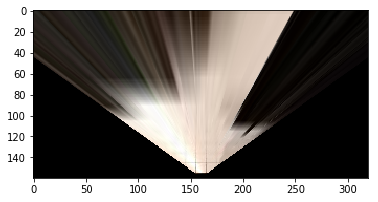

In [81]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dest, clip=False):
    M = cv2.getPerspectiveTransform(src, dest)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0])) # keep the same size as input
    return warped

# Define a calibration box in source (actual) and destination (desired) coordinates
# The source and destination points are defined to warp the image to a grid
# where each 10x10 pixel square represents 1 square meter
# The destination box will be 2 * dst_size on each side
dst_size = 5

# Set a bottom offset - bottom offset is in front of the rover a bit
bottom_offset = 5

source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

warped = perspect_transform(grid_img, source, destination, clip=False)

plt.imshow(warped)

In [91]:
def mask_image(img):  
    image=np.zeros_like(img)
    radius=np.int32(img.shape[0] / 2)
    axes = (radius,radius)
    angle=0;
    startAngle=0;
    endAngle=-180;
    center_X = np.int32(img.shape[1] / 2)
    center_Y = np.int32(img.shape[0])
    center=(center_X, center_Y)
    color=255
    mask = cv2.ellipse(image, center, axes, angle, startAngle, endAngle, color, -1) 
    
    masked = cv2.bitwise_and(img, img, mask=mask)
    return masked

masked = mask_image(warped)
plt.imshow(masked)

error: /home/travis/miniconda/conda-bld/conda_1486587071158/work/opencv-3.1.0/modules/core/src/arithm.cpp:241: error: (-215) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function binary_op


### Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

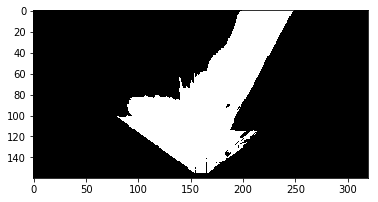

In [69]:
# TODO: Ultimately, you want your map to not just include navigable terrain but 
# also obstacles and the positions of the rock samples you're searching for. 
# Modify this function or write a new function that returns the pixel locations of 
# obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), 
# such that you can map these areas into world coordinates as well.
import operator

# Identify pixels above the threshold
# Above 160 works well for ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160), cmp_op=False):
    # Single channel of img, zeros
    color_select = np.zeros_like(img[:,:,0])
    
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]
    
    r, g, b = rgb_thresh
    
    # Default to above thresh
    if not cmp_op:
        cmp_op = operator.gt
    
    # Compare each pix to thresh
    thresh = (cmp_op(img_r, r) \
              & cmp_op(img_g, g) \
              & cmp_op(img_b, b))
        
    color_select[thresh] = 1
    
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

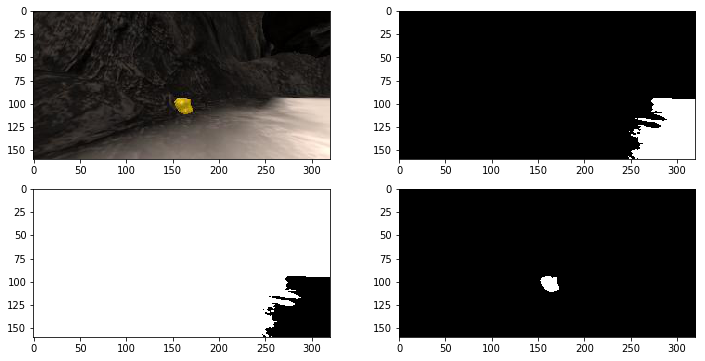

In [70]:
def color_thresh_terrain(img):
    return color_thresh(img, (160,160,160))

def color_thresh_obstacles(img):
    return color_thresh_terrain(img) ^ 1

def color_thresh_samples(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    return mask

img = mpimg.imread('../calibration_images/example_rock2.jpg')
#img = perspect_transform(img, source, destination)

fig = plt.figure(figsize=(12,6))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(color_thresh_terrain(img), cmap='gray')
plt.subplot(223)
plt.imshow(color_thresh_obstacles(img), cmap='gray')
plt.subplot(224)
plt.imshow(color_thresh_samples(img), cmap='gray')

### Coordinate Transformations
Define the functions used to do the coordinate transforms and apply them to an image

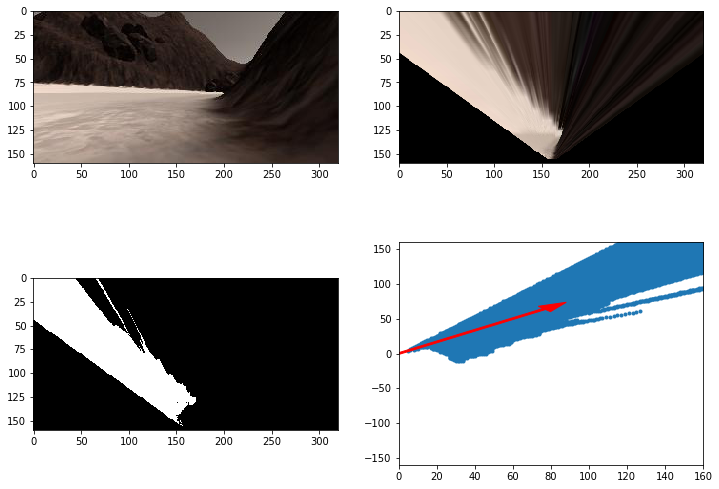

In [71]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    # Calculate pixel positions with reference to the rover position
    # being at the center bottom of the image
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(np.float)
    
    return x_pixel, y_pixel

def to_polar_coords(x_pixel, y_pixel):
    # Convert to radial coords
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    
    return dist, angles

def rotate_pix(xpix, ypix, yaw):
    # Apply rotation to pixel positions, input yaw angle in degrees
    yaw_rad = yaw * np.pi / 180
    x_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    y_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    
    return x_rotated, y_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Perform translation and convert to integer since pixel values cant be float
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    
    return xpix_translated, ypix_translated

def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Define a function to apply rotation and translation (and clipping)
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
  
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination, clip=False)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

## Read in saved data and ground truth map of the world

The next cell is all setup to read your saved data into a pandas dataframe. Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.

After that, we'll define a class to store telemetry data and pathnames to images. When you instantiate this class (data = Databucket()) you'll have a global variable called data that you can refer to for telemetry and map data within the process_image() function in the following cell.

In [72]:
import pandas as pd

df = pd.read_csv('../course_test_dataset/robot_log.csv', sep=';', decimal='.')
#print(list(df.columns.values))
csv_img_list = df["Path"].tolist() 

# Read in ground truth map and create a 3 channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Create a class to be the data container
class Databucket():
    def __init__(self):
        self.images = csv_img_list
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # A running index, -1 is a hack for moviepy, an extra iter
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        
# Instantiate a Databucket... will be a global variable/object
# that you can refer to in the process_image() function below

data = Databucket()

### Write a function to process stored images

Modify the process_image() function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping. The following cell is all set up to use this process_image() function in conjunction with the moviepy video processing package to create a video from the images you saved taking data in the simulator.

In short, you will be passing individual images into process_image() and building up an image called output_image that will be stored as one frame of video. You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).

To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process. Feel free to get creative!

In [96]:
def process_image(img):
    # Pass stored images to reading 
    # rover position and yaw angle from csv file
    
    # TODO:
    # 1) Define source and destination points for perspective transform
    
    # Define a calibration box in source (actual) and destination (desired) coordinates
    # The source and destination points are defined to warp the image to a grid
    # where each 10x10 pixel square represents 1 square meter
    # The destination box will be 2 * dst_size on each side
    dst_size = 5

    # Set a bottom offset - bottom offset is in front of the rover a bit
    bottom_offset = 5
    
    image = img
    source = np.float32([[14, 140], [301 ,140], [200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    
    # 2) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # NOTE: Doing threshold before transform
    terrain = color_thresh_terrain(img)
    obstacles = color_thresh_obstacles(img)
    samples = color_thresh_samples(img)
    
    # 3) Apply perspective transform
    warped_terrain = perspect_transform(terrain, source, destination)
    warped_obstacles = perspect_transform(obstacles, source, destination)
    warped_samples = perspect_transform(samples, source, destination)
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    rover_centric_terrain = rover_coords(warped_terrain)
    rover_centric_obstacles = rover_coords(warped_obstacles)
    rover_centric_samples = rover_coords(samples)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 10
    #  pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    px2world = lambda rov_coords: pix_to_world(rov_coords[0], rov_coords[1], data.xpos[data.count], 
                                                      data.ypos[data.count], data.yaw[data.count], 
                                                      data.worldmap.shape[0], scale)
    world_terrain = px2world(rover_centric_terrain)
    world_obstacles = px2world(rover_centric_obstacles)
    world_samples = px2world(rover_centric_samples)
    
    # 6) Update worldmap to be displayed on right side of screen
    #    Example: data.worldmap[obstackle_y_world, obstacle_x_world, 0] += 1
    #             data.worldmap[rock_y_world, rock_x_world, 1] += 1
    #             data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    #
    # NOTE: X and Y are reversed
    data.worldmap[world_obstacles[1], world_obstacles[0], 0] += 1
    data.worldmap[world_terrain[1], world_terrain[0], 2] += 10

    if samples.any():
        
        sample_dist, sample_angles = to_polar_coords(rover_centric_samples[0],
                                                     rover_centric_samples[1])
        sample_idx = np.argmin(sample_dist)
        sample_cX = world_samples[0][sample_idx]
        sample_cY = world_samples[1][sample_idx]
        
        #print(sample_cX, sample_cY)
        data.worldmap[np.int_(sample_cX), np.int_(sample_cY), 1] = 255
        
    # 7) Make a mosaic image, below is some sample code
    
    # First create a blank image, shape whatever
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    
    # Next, populate regions with various output
    # e.g. putting original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    
    # Create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)

    # Add the warped image in the upper right
    output_image[0:img.shape[0], img.shape[1]:] = warped
    
    # Add vision to lower right
    img_x = img.shape[0]
    img_y = img.shape[1]
    output_image[-img_x:, img_y:, 2] = warped_terrain * 255
    output_image[-img_x:, img_y:, 0] = warped_obstacles * 255
    output_image[-img_x:, img_y:, 1] = warped_samples * 255
    
    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    
    # Flip map overlay so y-axis points upward and add to output_image
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)
     
    data.count += 1 # Keep track of index in the Databucket()
    
    return output_image

### Make a video from processed image data
Use the moviepy library to process images and create a video

In [97]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define pathname to save the output
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize in case running multiple times
clip = ImageSequenceClip(data.images, fps=60) 
# Note that output will be sped up 
# because recording rate in simulator is 25 fps

new_clip = clip.fl_image(process_image) # NOTE: This function expects color images!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 283/283 [00:04<00:00, 59.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 2.62 s, sys: 84 ms, total: 2.7 s
Wall time: 5.16 s


#### The next cell shold function as an inline video player
If this fails to render the video, try running the following cell. Or check the output folder mp4.

In [98]:
output = '../output/test_mapping.mp4'
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [99]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </vide>'''.format(encoded_video.decode('ascii')))